In [164]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 400e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
10.33680342927128


<Quantity 1.77903395 arcsec>

# Setup Interfaces

In [4]:
fsm = ImageStream('fsm')

In [122]:
fsm.write(v_bias)
# fsm.write(zero)

In [147]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [145]:
npsf = 500
cam.set_roi(570, 900, npsf, client0)

In [146]:
cam.set_exptime(0.0001, client0)

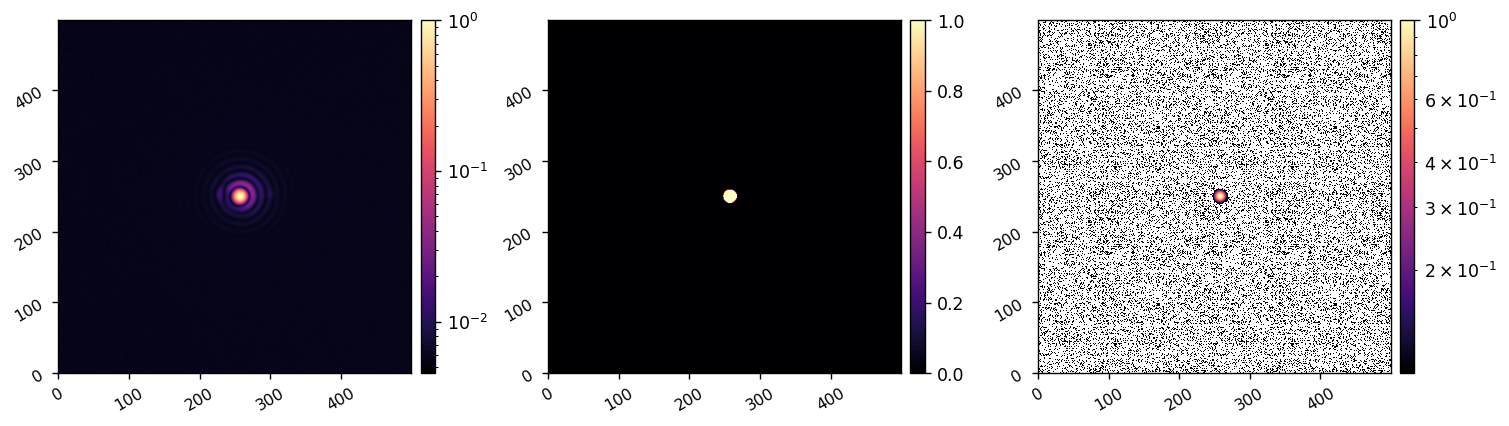

[256.72335962 249.36066437]


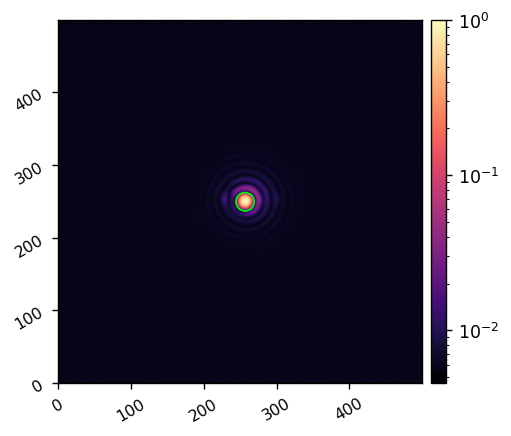

In [156]:
cam.Nframes = 100
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.1, plot=True)
print(cen)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [62]:
dynamic_range = (1200 * u.microradian).to(u.arcsec)
print(dynamic_range)

247.5177674965156 arcsec


In [207]:
fsm.write(zero)

In [206]:
fsm.write(v_bias)

In [203]:
v = fsm_utils.get_fsm_volts(tip=dynamic_range, tilt=0*u.arcsec)
v = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=-dynamic_range)
print(v)

[[50.]
 [14.]
 [86.]]


In [204]:
fsm.write(v)

In [ ]:
reload(fsm_utils)

Nsamps = 101
max_step = 10*u.arcsec
steps = np.linspace(-max_step, max_step, Nsamps)
v_steps = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    v_steps[i] = fsm_utils.get_fsm_volts(tip=steps[i], tilt=0*u.arcsec)
    # V = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=steps[i])

tsleep = 0.5
cam.Nframes = 100

# v_steps

In [194]:
data = {
    'zero_ims':[],
    'bias_ims':[],
    'step_ims':[],
    'desired_steps':steps,
    'step_volts':v_steps,
    'N':Nsamps,
    'NFRAMES':cam.Nframes,
    'settling_time':tsleep,
    'FPS':client0[f'campupil.fps.current'],
    'EXPTIME':client0[f'campupil.exptime.current']
}

for i in range(Nsamps):
    fsm.write(zero)
    time.sleep(tsleep)
    zero_im = cam.snap()
    fsm.write(v_bias)
    time.sleep(tsleep)
    bias_im = cam.snap()
    fsm.write(v_steps[i])
    step_im = cam.snap()
    time.sleep(tsleep)

    data['zero_ims'].append(copy.copy(zero_im))
    data['bias_ims'].append(copy.copy(bias_im))
    data['step_ims'].append(copy.copy(step_im))

fsm.write(zero)
time.sleep(tsleep)
fsm.write(v_bias)



In [195]:
utils.save_pickle(f'data/linearity/{today}_linearity_tip_2.pkl', data)

Saved data to:  data/linearity/20250122_linearity_tip_2.pkl


# Analyze data

In [ ]:
# data = utils.load_pickle('data/linearity/20250122_linearity_tip.pkl')

In [196]:
N = data['N']
# N = 101
zero_ims = data['zero_ims']
bias_ims = data['bias_ims']
step_ims = data['step_ims']

zero_cents = []
bias_cents = []
step_cents = []

cthresh = 0.1

for i in range(N):
    zero_cents.append( utils.centroid(zero_ims[i], thresh=cthresh, plot=0) )
    bias_cents.append( utils.centroid(bias_ims[i], thresh=cthresh, plot=0) )
    step_cents.append( utils.centroid(step_ims[i], thresh=cthresh, plot=0) )
    
zero_cents = np.array(zero_cents)
bias_cents = np.array(bias_cents)
step_cents = np.array(step_cents)


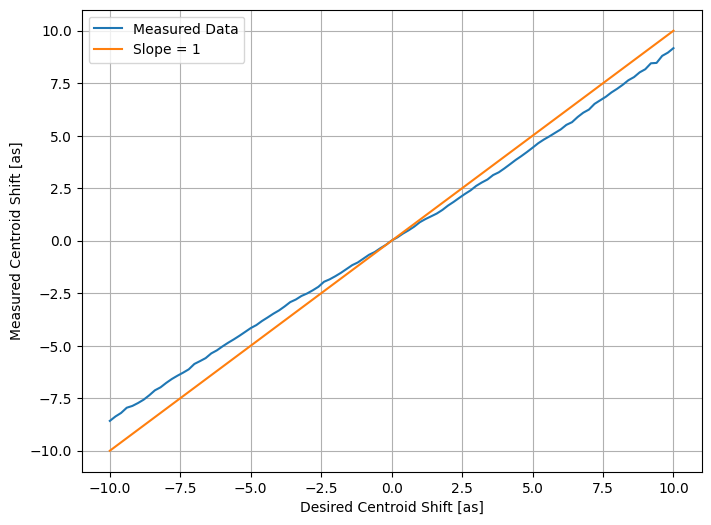

In [200]:
steps_pix = step_cents - bias_cents
steps_as = steps_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)

total_steps_pix = np.sqrt( np.sum( np.square(steps_pix), axis=1) )
total_steps_as = np.sqrt( np.sum( np.square(steps_as), axis=1) )

total_steps_as[:N//2] *= -1

fig = plt.figure(figsize=(8,6))
plt.subplot(111)
plt.plot(data['desired_steps'], total_steps_as, label='Measured Data')
plt.plot(data['desired_steps'], data['desired_steps'], label='Slope = 1')
plt.grid()
plt.ylabel('Measured Centroid Shift [as]')
plt.xlabel('Desired Centroid Shift [as]')
# plt.xlim([-1,1])
# plt.ylim([-1,1])
plt.legend()


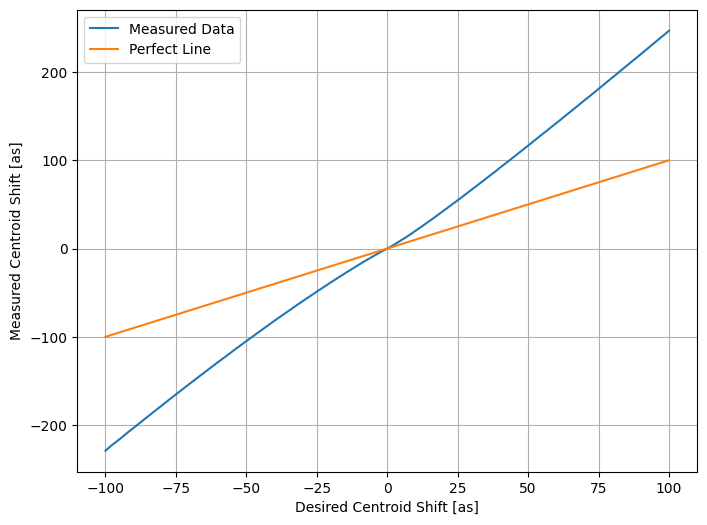

In [173]:
steps_pix = step_cents - bias_cents
steps_as = steps_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)

total_steps_pix = np.sqrt( np.sum( np.square(steps_pix), axis=1) )
total_steps_as = np.sqrt( np.sum( np.square(steps_as), axis=1) )

total_steps_as[:N//2] *= -1

fig = plt.figure(figsize=(8,6))
plt.subplot(111)
plt.plot(data['desired_steps'], total_steps_as, label='Measured Data')
plt.plot(data['desired_steps'], data['desired_steps'], label='Perfect Line')
plt.grid()
plt.ylabel('Measured Centroid Shift [as]')
plt.xlabel('Desired Centroid Shift [as]')
plt.legend()


In [165]:
total_steps_as

<Quantity [-1.14524711e+02, -1.11711943e+02, -1.09255628e+02,
           -1.06710965e+02, -1.04072406e+02, -1.01581639e+02,
           -9.90153415e+01, -9.64663177e+01, -9.39537212e+01,
           -9.14048567e+01, -8.88910603e+01, -8.63734865e+01,
           -8.38805724e+01, -8.13918253e+01, -7.89218185e+01,
           -7.64596946e+01, -7.40339133e+01, -7.15690918e+01,
           -6.91169110e+01, -6.66955462e+01, -6.42871310e+01,
           -6.19190487e+01, -5.95372318e+01, -5.71202466e+01,
           -5.47890716e+01, -5.24318730e+01, -5.01088340e+01,
           -4.77862395e+01, -4.54729464e+01, -4.31794114e+01,
           -4.08728137e+01, -3.86541187e+01, -3.64278433e+01,
           -3.42132075e+01, -3.19764939e+01, -2.97816333e+01,
           -2.76306003e+01, -2.54930812e+01, -2.33655191e+01,
           -2.12417172e+01, -1.91639016e+01, -1.71062183e+01,
           -1.50639463e+01, -1.30516513e+01, -1.10689519e+01,
           -9.09409735e+00, -7.16548425e+00, -5.30325879e+00,
        